<a href="https://colab.research.google.com/github/MihaiDogariu/CV3/blob/main/laborator/CV%203%20-%20Lab%20%233.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elemente fundamentale ale unei rețele neuronale
Laboratorul curent abordează mai multe aspecte de bază ale rețelelor neuronale. Aplicația prezentată mai jos are scopul de a prezice vremea pentru ziua următoare. Pornind de la o bază de date cu observații ale mai multor parametri meteorologici pentru ziua curentă, se dorește să prezicem dacă în ziua următoare va ploua sau nu.

In [1]:
import torch
import pandas as pd # utilitar folosit pentru gestionarea bazelor de date
from sklearn.model_selection import train_test_split # va fi utilizat pentru împărțirea bazei de date în subseturile dorite
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

RANDOM_SEED = 1 # pentru reproductibilitate
torch.manual_seed(RANDOM_SEED)

## 1. Alegerea datelor

Descarcati baza de date ["Rain in Australia"](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package?resource=download):

In [2]:
!gdown 1D-Ua952YzK95yPCJxzr8SWu7ZJGVROJd

Downloading...
From: https://drive.google.com/uc?id=1D-Ua952YzK95yPCJxzr8SWu7ZJGVROJd
To: /content/weatherAUS.csv
100% 14.1M/14.1M [00:00<00:00, 210MB/s]


Fiecare intrare din baza de date contine 23 campuri de informatii <-> 23 de descriptori. Putem analiza o parte din baza de date cu codul de mai jos. Utilitarul `pandas` este specializat în gestionarea bazelor de date si are funcții speciale pentru citirea formatelor de date comune.

In [3]:
df = pd.read_csv('weatherAUS.csv')
df.head(15)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,No
6,2008-12-07,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,...,49.0,19.0,1009.6,1008.2,1.0,NaN,18.1,24.6,No,No
7,2008-12-08,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,No
8,2008-12-09,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,...,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,No,Yes
9,2008-12-10,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,...,58.0,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,Yes,No


In [4]:
# Numărul total de intrări în baza de date și dimensiunea unei intrări:
print(df.shape)

(145460, 23)


##2. Pre-procesarea datelor

In [5]:
# Baza de date conține o gamă largă de atribute, însă nu ne interesează toate.
# Facem o listă cu descriptorii care sunt de interes dintre toți cei disponibili
# TODO: testați cu diferiți descriptori pentru a vedea care dintre ei are o influență mai mare asupra capacității de predicție - adăugați cel puțin 2 alți descriptori existenți în baza de date
keep = ['MinTemp', 'MaxTemp', 'Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

# Din întreaga bază de date păstrăm doar datele asociate descriptorilor selectați mai sus
df_keep = df[keep]

# Unii dintre descriptori sunt reprezentați de valori logice binare (yes/no). Acestea trebuie interpretate sub forma unor valori pe care o rețea neuronală le poate procesa, adică valori numerice.
df_keep['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df_keep['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

# De asemenea, baza de date conține intrări pentru care nu sunt disponibili toți descriptorii (valori de NaN). O soluție trivială este să eliminăm complet aceste intrări.
# TODO: propuneți o altă strategie de abordare a datelor incomplete în acest context.
df_keep = df_keep.dropna(how='any')
df_keep.head(15)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,MinTemp,MaxTemp,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,13.4,22.9,0.6,22.0,1007.7,0.0,0.0
1,7.4,25.1,0.0,25.0,1010.6,0.0,0.0
2,12.9,25.7,0.0,30.0,1007.6,0.0,0.0
3,9.2,28.0,0.0,16.0,1017.6,0.0,0.0
4,17.5,32.3,1.0,33.0,1010.8,0.0,0.0
5,14.6,29.7,0.2,23.0,1009.2,0.0,0.0
6,14.3,25.0,0.0,19.0,1009.6,0.0,0.0
7,7.7,26.7,0.0,19.0,1013.4,0.0,0.0
8,9.7,31.9,0.0,9.0,1008.9,0.0,1.0
9,13.1,30.1,1.4,27.0,1007.0,1.0,0.0


In [6]:
# Afișăm numărul de zile în care (nu) a plouat, în valori absolute:
print("Numarul de zile in care nu a plouat: ", df_keep['RainTomorrow'].value_counts()[0])
print("Numarul de zile in care a plouat: ", df_keep['RainTomorrow'].value_counts()[1])

# Afișăm numărul de zile în care (nu) a plouat, în valori relative:
df_keep['RainTomorrow'].value_counts() / df_keep.shape[0]

Numarul de zile in care nu a plouat:  96989
Numarul de zile in care a plouat:  27550


0.0    0.778784
1.0    0.221216
Name: RainTomorrow, dtype: float64

 Se observă că baza de date este dezechilibrată - numarul de zile in care nu a plouat este de ~3.5x mai mare decat numarul de zile in care a plouat.

In [7]:
# Putem alege o tehnică de echilibrare a bazei de date prin sub-eșantionarea clasei puternic reprezentată
# TODO: rulați algoritmul cu diferite grade de dezechilibru între cele 2 clase:
# no_rain = 3.5x rain (original)
# no_rain = 3x rain
# no_rain = 2x rain
under_sample = True

if under_sample:
  rain = df_keep[df_keep['RainTomorrow']==1] # selectăm doar intrările pentru care a fost înregistrată ploaie
  no_rain = df_keep[df_keep['RainTomorrow']==0] # selectăm doar intrările pentru care nu a fost înregistrată ploaie
  no_rain = no_rain.sample(n=len(rain)) # alegem len(rain) eșantioane aleatoare din baza de date no_rain
  df_keep = pd.concat([rain,no_rain],axis=0) # concatenăm cele 2 subseturi de date, formând o bază de date cu gradul dorit de dezechilibru

# TODO: propuneți o metodă de over_sample, în care clasa slab reprezentată să fie augmentată până la dimensiunea clasei puternic reprezentată

print("Numarul de zile in care a plouat: ", df_keep['RainTomorrow'].value_counts()[1])
print("Numarul de zile in care nu a plouat: ", df_keep['RainTomorrow'].value_counts()[0])

Numarul de zile in care a plouat:  27550
Numarul de zile in care nu a plouat:  27550


Baza de date nou formată este acum împărțită în intrări și ieșiri. Ieșirile reprezintă etichetele datelor de intrare. În acest context, etichetele sunt decizia plouă/nu plouă.

In [8]:
x = df_keep[keep[:-1]]
y = df_keep[keep[-1]]

Împărțim setul de date în train-val-test după regula 70-15-15. Funcția `train_test_split` realizează împărțirea unui set de date în doar 2 subseturi. Prin urmare, trebuie aplicată de două ori:
1.   se împarte baza de date originală în `train_val` și `test`;
2.   se împarte `train_val` în `train` și `val`.



In [9]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Împărțirea bazei originale în 'train_val' și 'test':
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=test_ratio)
print('Dimensiuni baza train_val: {}\tDimensiuni baza test: {}'.format(x_train_val.shape, x_test.shape))

# Împărțirea 'train_val' în 'train' și 'val'
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=val_ratio/(val_ratio + train_ratio)) 
print('Dimensiuni baza train: {}\tDimensiuni baza val: {}\tDimensiuni baza test:{}'.format(x_train.shape, x_val.shape, x_test.shape))

Dimensiuni baza train_val: (46835, 6)	Dimensiuni baza test: (8265, 6)
Dimensiuni baza train: (38570, 6)	Dimensiuni baza val: (8265, 6)	Dimensiuni baza test:(8265, 6)


Trecem toate datele din format `pandas.DataFrame` în format `Tensor` pentru a putea fi procesate de către PyTorch.

In [10]:
x_train = torch.from_numpy(x_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

x_val = torch.from_numpy(x_val.to_numpy()).float()
y_val = torch.squeeze(torch.from_numpy(y_val.to_numpy()).float())

x_test = torch.from_numpy(x_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

torch.Size([38570, 6]) torch.Size([38570])
torch.Size([8265, 6]) torch.Size([8265])
torch.Size([8265, 6]) torch.Size([8265])


##3. Antrenarea și validarea modelului

Primul pas este crearea modelului de rețea neuronală. În PyTorch, modelele sunt crate, de regulă, sub forma unei clase care moștenește clasa `torch.nn.Module`. Modelul trebuie să definească 2 funcții:


1.   `__init__()` - stabilește structura straturilor rețelei;
2.   `forward()` - stabilește comportamentul în faza de feedforward.



In [11]:
class Net(torch.nn.Module):

  def __init__(self, n_features): # argumentul n_features este folosit pentru a stabili dimensiunea stratului de intrare la aceeași valoare cu dimensiunea intrării din baza de date
    super(Net, self).__init__()
    self.fc1 = torch.nn.Linear(n_features, 5) # strat fully connected, care leagă intrarea la un strat cu 5 neuroni
    self.fc2 = torch.nn.Linear(5, 3) # strat fully connected, care leagă 5 neuroni din stratul precedent la un strat cu 3 neuroni
    self.fc3 = torch.nn.Linear(3, 1) # strat fully connected, care leagă 3 neuroni din stratul precedent la un strat cu un singur neuron, reprezentând ieșirea sistemului

  def forward(self, x): # aplicarea funcțiilor de activare după fiecare strat fully connected 
    x = torch.nn.functional.relu(self.fc1(x))
    x = torch.nn.functional.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

# TODO: încercați diferite variații pentru modelul de mai jos. Idei legate de ce puteți modifica:
# 1. numărul de neuroni/strat;
# 2. numărul de straturi;
# 3. funcțiile de activare
# !!!Atenție: dimensiunea de intrare în primul strat trebuie să fie mereu egală cu dimensiunea intrărilor din baza de date de antrenare
# !!!Atenție: dimensiunea de ieșire din ultimul strat trebuie mereu să fie 1 pentru această aplicație - ne dorim să obținem o singură valoare care ne spune dacă va ploua sau nu va ploua în ziua următoare
# !!!Atenție: ieșirea trebuie să poată fi interpretată cu ușurință într-o decizie binară.

Inițializarea rețelei, a funcției de cost și a optimizatorului 

In [12]:
net=Net(x_train.shape[1]) # apelează funcția Net.__init()__ pentru a inițializa modelul rețelei neuronale
criterion = torch.nn.BCELoss() # funcția de cost este Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(net.parameters(), lr=0.01) # optimizatorul Adam

# TODO: încercați diferițiti hiper-parametri:
# 1. selectați alt optimizator
# 2. selectați valori diferite pentru rata de învățare

Încărcarea tuturor datelor și funcțiilor pe GPU

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_train = x_train.to(device)
y_train = y_train.to(device)

x_val = x_val.to(device)
y_val = y_val.to(device)

x_test = x_test.to(device)
y_test = y_test.to(device)

net = net.to(device)

criterion = criterion.to(device)

# TODO: rulați algoritmii atât pe cpu, cât și pe gpu pentru a observa diferența de performanță

Funcții auxiliare

In [14]:
# Funcție de calcul a acurateții - se va discuta în cursurile următoare.
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

# Funcție de rotunjire a unui tensor la un anumit număr de zecimale 
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

Antrenarea propriu-zisă

In [15]:
for epoch in range(1000):
    
    y_pred = net(x_train) # apelează funcția Net.forward(x_train) <-> execută forward propagation
    y_pred = torch.squeeze(y_pred) # se elimină toate dimensiunile de 1 ale tensorului
    train_loss = criterion(y_pred, y_train) # se calculează valoarea funcției de cost
    
    if epoch % 100 == 0: # vom afișa valorile înregistrate la fiecare 100 de epoci pe baza de date de validare
      train_acc = calculate_accuracy(y_train, y_pred) # calculăm acuratețea obținută pe baza de date de antrenare

      y_val_pred = net(x_val) # calculăm ieșirea rețelei pentru baza de date de validare
      y_pred = torch.squeeze(y_pred) # se elimină toate dimensiunile de 1 ale tensorului
      y_val_pred = torch.squeeze(y_val_pred) # se elimină toate dimensiunile de 1 ale tensorului

      val_loss = criterion(y_val_pred, y_val) # se calculează funcția de cost pentru baza de date de validare

      val_acc = calculate_accuracy(y_val, y_val_pred) # se calculează acuratețea obținută ăe baza de date de validare
      print("epoch {}\nTrain set - loss: {}, accuracy: {}\nTest  set - loss: {}, accuracy: {}"
            .format(epoch, 
                    round_tensor(train_loss), round_tensor(train_acc), 
                    round_tensor(val_loss), round_tensor(val_acc)))
    
    optimizer.zero_grad() # se anulează gradienții existenți pentru a preveni acumularea lor de la o epocă la alta
    
    train_loss.backward() # se calculează gradienții pentru iterația actuală
    
    optimizer.step() # se realizează propagarea înapoi a gradienților calculați la instrucțiunea precedentă și actualizarea ponderilor rețelei

epoch 0
Train set - loss: 2.866, accuracy: 0.502
Test  set - loss: 2.866, accuracy: 0.502
epoch 100
Train set - loss: 0.53, accuracy: 0.74
Test  set - loss: 0.533, accuracy: 0.736
epoch 200
Train set - loss: 0.527, accuracy: 0.739
Test  set - loss: 0.53, accuracy: 0.737
epoch 300
Train set - loss: 0.524, accuracy: 0.742
Test  set - loss: 0.527, accuracy: 0.737
epoch 400
Train set - loss: 0.521, accuracy: 0.743
Test  set - loss: 0.523, accuracy: 0.74
epoch 500
Train set - loss: 0.521, accuracy: 0.743
Test  set - loss: 0.522, accuracy: 0.742
epoch 600
Train set - loss: 0.521, accuracy: 0.744
Test  set - loss: 0.522, accuracy: 0.743
epoch 700
Train set - loss: 0.52, accuracy: 0.743
Test  set - loss: 0.522, accuracy: 0.742
epoch 800
Train set - loss: 0.52, accuracy: 0.743
Test  set - loss: 0.522, accuracy: 0.742
epoch 900
Train set - loss: 0.52, accuracy: 0.743
Test  set - loss: 0.522, accuracy: 0.742


După antrenarea și optimizarea algoritmului pe bazele `train` și `val`, urmează validarea algoritmului pe baza de date care nu a mai fost utilizată până acum, subsetul `test`.

In [16]:
classes = ['No rain', 'Raining']

y_pred = net(x_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.72      0.78      0.75      4059
     Raining       0.77      0.71      0.74      4206

    accuracy                           0.75      8265
   macro avg       0.75      0.75      0.75      8265
weighted avg       0.75      0.75      0.75      8265



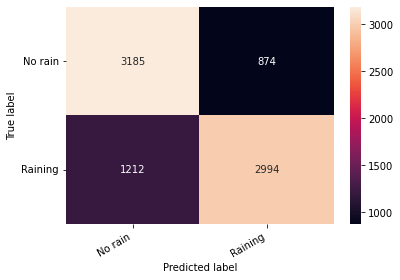

In [17]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');